# Question 1

### Exercise 1.(b)

In [2]:
#1-hidden layer neural network y=w2^T*tanh(w1*x+b1)+b2
#W1: 20 *10
#W2: 1 * 20

import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
import torch

#generate data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

h_1 = 20
h_2 = 1
param_dict = {"W1": torch.randn(h_1,10,device=device,requires_grad=True),
              "b1":torch.randn(h_1,1,device=device,requires_grad=True),
              "W2":torch.randn(h_1,h_2,device=device,requires_grad=True),
              "b2":torch.randn(1, device=device,requires_grad=True)}

#generate data
x = torch.randn(100,10,1,device=device)
y = torch.randn(100,1,1,device=device)


def my_nn(x,param_dict):
    
    x = x.clone().detach().requires_grad_(True)
    x = torch.tanh(param_dict["W1"]@x+param_dict["b1"])
    x = param_dict["W2"].T@x+param_dict["b2"]
    return x

def my_MAE(y_hat,y):
    # abs value
    return torch.mean(torch.abs(y_hat-y))

def my_loss_grad(y_hat,y):
    return torch.sign(y_hat-y)

def my_nn_grad(x,y_hat,y,param_dict):

    x = x.clone().detach().requires_grad_(True)
    y_hat = y_hat.clone().detach().requires_grad_(True)
    y = y.clone().detach().requires_grad_(True)
    
    grad_dict = {}
    mlg = my_loss_grad(y_hat,y)
    grad_dict["b2"] = torch.mean(mlg)
    # my_loss_grad(y_hat,y) is 100*1*1
    # torch.tanh(param_dict["W1"]@x+param_dict["b1"]) is 100*20*1
    pre_w2 = mlg * torch.tanh(param_dict["W1"]@x+param_dict["b1"])
    grad_dict["W2"] = torch.mean(pre_w2,dim=0)
    pre_b1 = mlg * param_dict["W2"] * (1-torch.tanh(param_dict["W1"]@x+param_dict["b1"])**2)
    grad_dict["b1"] = torch.mean(pre_b1,dim=0)
    pre_w1 = pre_b1 @ x.permute(0,2,1)
    grad_dict["W1"] = torch.mean(pre_w1,dim=0)

    return grad_dict

def torch_grad_check(x,y,param_dict,eps=1e-6):
    # check my_nn_grad and torch.autograd.grad
    print("Floating point error tolerance is: ", eps)
    y_hat = my_nn(x,param_dict)
    #backwards
    loss = my_MAE(y_hat,y)
    loss.backward()
    grad_dict = my_nn_grad(x,y_hat,y,param_dict)
    for key in param_dict.keys():
        #use torch.linalg.norm to compare if smaller than eps
        print ("Key is: ", key)
        #print ("My grad is: ", grad_dict[key])
        #print ("Torch grad is: ", param_dict[key].grad)
        diff = torch.linalg.norm(grad_dict[key]-param_dict[key].grad)
        print ("Difference is: ", diff)
        #assert diff < eps, print error message if failed, print success message if passed
        assert diff < eps, "error in "+key
        print("Success in "+key)

   



#check my_nn_grad and torch.autograd
torch_grad_check(x,y,param_dict)






Floating point error tolerance is:  1e-06
Key is:  W1
Difference is:  tensor(1.0802e-07, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Success in W1
Key is:  b1
Difference is:  tensor(2.3591e-08, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Success in b1
Key is:  W2
Difference is:  tensor(9.8421e-08, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Success in W2
Key is:  b2
Difference is:  tensor(0., device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Success in b2


### Exercise 1.(c)

In [3]:
# Train this model on the sklearn California Housing Prices datasets
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing

import scipy
import sklearn
import sklearn.datasets
import sklearn.linear_model
from torch.utils import data


# Generate a random California housing dataset
# half of the data is used for training, the other half for testing
# the data is normalized to have zero mean and unit variance
scaler = sklearn.preprocessing.StandardScaler()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    scaler.fit_transform(sklearn.datasets.fetch_california_housing().data),
    sklearn.datasets.fetch_california_housing().target,
    test_size=0.5,
    random_state=42)

train_batch_size = 64
test_batch_size = 64

# dataloader to gpu
train_dataset = data.TensorDataset(torch.tensor(X_train,device=device, dtype=torch.float32), torch.tensor(y_train,device=device, dtype=torch.float32))
train_loader = data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataset = data.TensorDataset(torch.tensor(X_test,device=device, dtype=torch.float32), torch.tensor(y_test,device=device, dtype=torch.float32))
test_loader = data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

#validation set from training set
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [int(0.8*len(train_dataset)), int(0.2*len(train_dataset))])
val_loader = data.DataLoader(val_dataset, batch_size=test_batch_size, shuffle=True)



# convenient xavier initialization, taking an existing dictionary of parameters

def xavier_init(param_dict):
    for key in param_dict.keys():
        if "W" in key:
            torch.nn.init.xavier_uniform_(param_dict[key])
        else:
            torch.nn.init.zeros_(param_dict[key])
        param_dict[key].requires_grad_(True)
    return param_dict

num_epochs = 40
optimizer = torch.optim.Adam(param_dict.values(), lr=0.001)
lr_scehudler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
loss_fn = torch.nn.MSELoss()


#change w1 to 20*8 instead of 20*10
param_dict["W1"] = torch.randn(h_1,8,device=device,requires_grad=True)
param_dict = xavier_init(param_dict)


train_loss_per_epoch = []
val_loss_per_epoch = []
test_loss_per_epoch = []

for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        y_hat = my_nn(x.T,param_dict)
        y_hat = y_hat.squeeze()
        loss = loss_fn(y_hat,y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss_per_epoch.append(train_loss/len(train_loader))

    #validation
    val_loss = 0
    for batch_idx, (x, y) in enumerate(val_loader):
        y_hat = my_nn(x.T,param_dict)
        y_hat = y_hat.squeeze()
        loss = loss_fn(y_hat,y)
        val_loss += loss.item()
    val_loss_per_epoch.append(val_loss/len(val_loader))
    
    #test
    test_loss = 0
    for batch_idx, (x, y) in enumerate(test_loader):
        y_hat = my_nn(x.T,param_dict)
        y_hat = y_hat.squeeze()
        loss = loss_fn(y_hat,y)
        test_loss += loss.item()
    test_loss_per_epoch.append(test_loss/len(test_loader))

    lr_scehudler.step(val_loss_per_epoch[-1])

    print("Epoch: ", epoch+1, "Train loss: ", train_loss_per_epoch[-1], "Val loss: ", val_loss_per_epoch[-1], "Test loss: ", test_loss_per_epoch[-1])



Epoch:  1 Train loss:  5.044032322035895 Val loss:  3.3316544691721597 Test loss:  3.393525270768154
Epoch:  2 Train loss:  2.5859341290262012 Val loss:  1.9377626036152695 Test loss:  1.9524018433358934
Epoch:  3 Train loss:  1.721601414091793 Val loss:  1.5419075886408489 Test loss:  1.4871438531963914
Epoch:  4 Train loss:  1.3943074684084198 Val loss:  1.2730701330936316 Test loss:  1.2506829032927385
Epoch:  5 Train loss:  1.197239801471616 Val loss:  1.115936729041013 Test loss:  1.09769755307539
Epoch:  6 Train loss:  1.0572793358637962 Val loss:  0.9786306204217853 Test loss:  0.9740997012014743
Epoch:  7 Train loss:  0.9532213448374359 Val loss:  0.8838369701847886 Test loss:  0.8931483902313091
Epoch:  8 Train loss:  0.879164864803538 Val loss:  0.8152112274458914 Test loss:  0.8267838559400889
Epoch:  9 Train loss:  0.8241120387374619 Val loss:  0.7637008609193744 Test loss:  0.7833703031510483
Epoch:  10 Train loss:  0.7845521986852457 Val loss:  0.7297153779954622 Test los

# Question 2

### Exercise 2.(a)

In [44]:
def generate_dict(L,D,K,P):
    param_dict = {}
    param_dict["W1"] = torch.randn(K,D,device=device)
    for i in range(2,L+1):
        param_dict["W"+str(i)] = torch.randn(K,K,device=device)
    param_dict["WF"] = torch.randn(P,K,device=device)
    return param_dict

def my_nn_2a(x,L,param_dict):
    x = param_dict["W1"]@x
    for i in range(2,L+1):
        x = param_dict["W"+str(i)]@torch.tanh(x)
    x = param_dict["WF"]@torch.tanh(x)
    return x

# backward automatic differentiation from scratch
# using the chain rule

def my_backward_2a(x,L,param_dict):
    P = param_dict["WF"].shape[0]
    D = x.shape[0]
    #forward pass
    x = x.clone().detach().requires_grad_(True)
    x = param_dict["W1"]@x
    tanh_outputs =[x]
    for i in range(2,L+1):
        x = param_dict["W"+str(i)]@torch.tanh(x)
        tanh_outputs.append(x)
    x = param_dict["WF"]@torch.tanh(x)
    #backward pass for jacobian
    df_intermediate = torch.diag(1-torch.tanh(tanh_outputs[-1])**2)
    df_intermediate = param_dict["WF"]@df_intermediate
    for i in range(L,1,-1):
        df_intermediate = df_intermediate@ param_dict["W"+str(i)]@torch.diag(1-torch.tanh(tanh_outputs[i-2])**2)
    df_intermediate = df_intermediate@param_dict["W1"]
    #copy df_intermediate to df_dx
    return df_intermediate


 
    

epsilon = 1e-2
    

    
D = 2
K= 30
P = 10
L = 10
param_dict = generate_dict(L,D,K,P)

start = time.time()
for i in range(1000):
    test = torch.randn(D,device=device,requires_grad=True)
    my_J = my_backward_2a(test,L,param_dict)
    J_autograd = torch.autograd.functional.jacobian(lambda x: my_nn_2a(x,L,param_dict),test,create_graph=True,strategy="reverse-mode")
    #assert, print two jacobians if they are not equal
    assert torch.allclose(my_J,J_autograd,atol=epsilon), print(my_J,J_autograd)
    #Get time taken
end = time.time()
print("Time taken for 1000 iterations: ", end-start) 
print ("Jacobian is correct")
    

    
        

        
    
        


        

Time taken for 1000 iterations:  9.11955213546753
Jacobian is correct


### Exercise 2.(b)

In [45]:
def my_forward_2b(x,L,param_dict):
    x = param_dict["W1"]@x
    df_dx = param_dict["W1"]
    for i in range(2,L+1):
        x = torch.tanh(x)
        #foward automatic differentiation
        df_intermediate = torch.diag(1-x**2)
        df_dx = param_dict["W"+str(i)]@df_intermediate@df_dx
        x = param_dict["W"+str(i)]@x
    x = torch.tanh(x)
    df_intermediate = torch.diag(1-x**2)
    df_dx = param_dict["WF"]@df_intermediate@df_dx
    x = param_dict["WF"]@x
    return df_dx

param_dict = generate_dict(L,D,K,P)

start = time.time()
for i in range(1000):
    test_2b = torch.randn(D,device=device,requires_grad=True)
    my_J_2b = my_forward_2b(test_2b,L,param_dict)
    J_autograd_2b = torch.autograd.functional.jacobian(lambda x: my_nn_2a(x,L,param_dict),test_2b, strategy="forward-mode", vectorize=True)
    #assert, print two jacobians if they are not equal
    assert torch.allclose(my_J_2b,J_autograd_2b,atol=epsilon), print(my_J_2b,J_autograd_2b)
end = time.time()
print("Time taken for 1000 iterations: ", end-start)
print ("Jacobian is correct")


Time taken for 1000 iterations:  4.200482368469238
Jacobian is correct


### Exercise 2(c)

In [52]:
#Run on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on GPU: ", torch.cuda.is_available())

test_l = [3,5,10]

D= 1000
K = 1000
P =1

test = torch.randn(D,device=device,requires_grad=True)



print("""When D,K,P are large (1000,1000,1), the reverse mode is faster than the forward mode.""")

for L in test_l:
    print("L = ", L)
    param_dict = generate_dict(L,D,K,P)
    
    start = time.time()
    for i in range(1000):
        my_J = my_backward_2a(test,L,param_dict)
    end = time.time()
    print ("Time taken for 1000 iterations of backward with L = ", L, " is ", time.time()-start)
    start = time.time()
    for i in range(1000):
        my_J_2b = my_forward_2b(test,L,param_dict)
    end = time.time()
    print ("Time taken for 1000 iterations of forward with L =  ", L, " is ", time.time()-start)
 


Running on GPU:  True
When D,K,P are large (1000,1000,1), the reverse mode is faster than the forward mode.
L =  3
Time taken for 1000 iterations of backward with L =  3  is  0.5629339218139648
Time taken for 1000 iterations of forward with L =   3  is  0.7463889122009277
L =  5
Time taken for 1000 iterations of backward with L =  5  is  0.8709812164306641
Time taken for 1000 iterations of forward with L =   5  is  1.5786635875701904
L =  10
Time taken for 1000 iterations of backward with L =  10  is  1.6397125720977783
Time taken for 1000 iterations of forward with L =   10  is  3.675320863723755


In [53]:
#Run on CPU
device = "cpu"
print("Running on CPU:")

test_l = [3,5,10]

D=1000
P=1
K=1000

test= torch.randn(D,device=device,requires_grad=True)


print("""When D,K,P are large (1000,1000,1), the reverse mode is faster than the forward mode.""")



for L in test_l:
    print("L = ", L)
    param_dict = generate_dict(L,D,K,P)
    start = time.time()
    for i in range(1000):
        my_J = my_backward_2a(test,L,param_dict)
    end = time.time()
    print ("Time taken for 1000 iterations of backward with L = ", L, " is ", (end-start))
    start = time.time()
    for i in range(1000):
        my_J_2b = my_forward_2b(test,L,param_dict)
    end = time.time()
    print ("Time taken for 1000 iterations of forward with L =  ", L, " is ", (end-start))
 

Running on CPU:
When D,K,P are large (1000,1000,1), the reverse mode is faster than the forward mode.
L =  3
Time taken for 1000 iterations of backward with L =  3  is  3.24117112159729
Time taken for 1000 iterations of forward with L =   3  is  21.133321046829224
L =  5
Time taken for 1000 iterations of backward with L =  5  is  5.777544736862183
Time taken for 1000 iterations of forward with L =   5  is  41.2066969871521
L =  10
Time taken for 1000 iterations of backward with L =  10  is  11.320931434631348
Time taken for 1000 iterations of forward with L =   10  is  91.34891438484192


# Question 4

### Exercise 4a) & 4b)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import torch.nn as nn

class My_nn_4a(nn.Module):
    def __init__(self,depth):
        super(My_nn_4a,self).__init__()
        self.depth = depth
        self.input_layer = nn.Linear(784,50)
        self.layers = nn.ModuleList([nn.Linear(50,50) for i in range(depth-1)])
        self.output_layer = nn.Linear(50,10)
        self.activation = nn.Tanh()

    def forward(self,x):
        x = x.view(-1,784)
        x= self.input_layer(x)
        x = self.activation(x)
        #x.retain_grad()
        for i in range(self.depth-1):
            x = self.layers[i](x)
            x = self.activation(x)
            #x.retain_grad()
        x = self.output_layer(x)
        return x
    
    def initialize_weights(self,d, xavier = False):
        #use torch.nn.init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if xavier:
                    d = np.sqrt(6/(m.in_features + m.out_features))
                    nn.init.uniform_(m.weight, -d, d)
                    nn.init.zeros_(m.bias)
                else:
                    nn.init.uniform_(m.weight, -d, d)
                    nn.init.zeros_(m.bias)

    # use cross entropy loss
    def loss(self, x, y):
        return nn.CrossEntropyLoss()(self.forward(x), y)

    




### Exercise 4c)

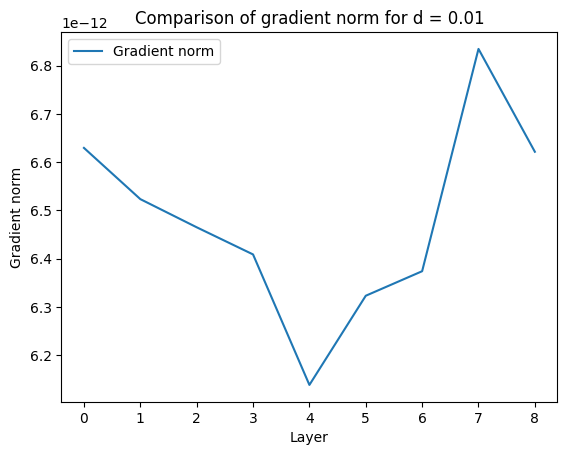

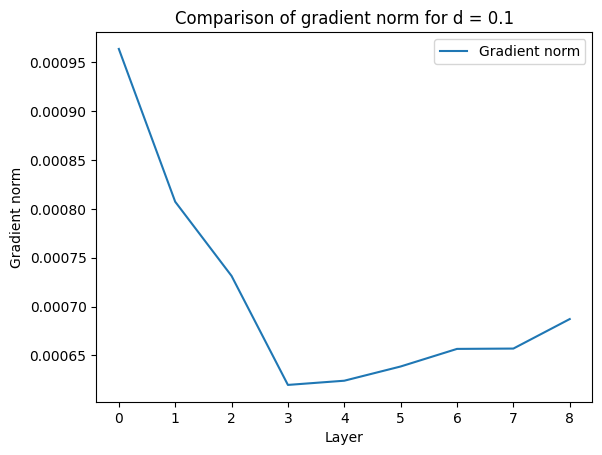

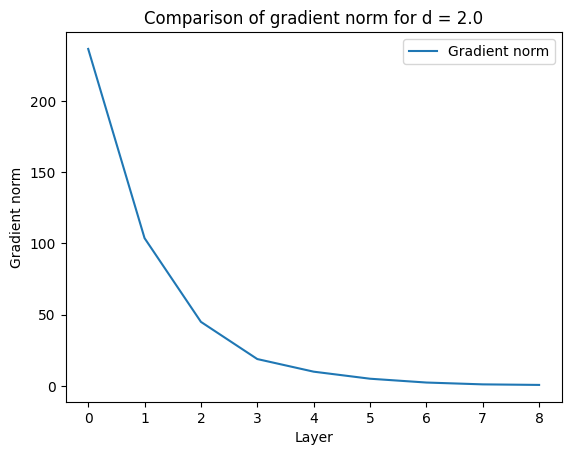

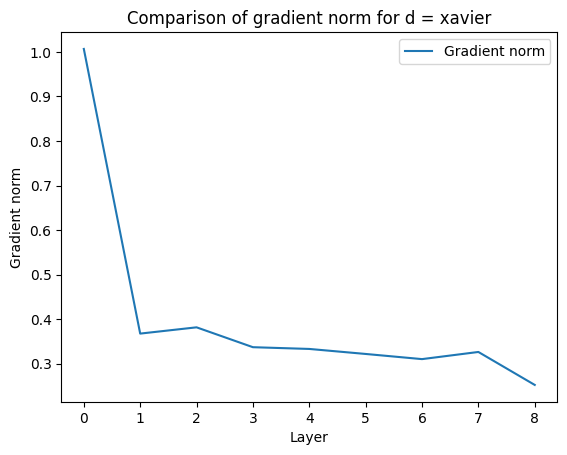

In [9]:
#forward and backward a minibatch of 256 MNIST digits through the network with depth 8.


from torchvision import datasets, transforms
#load MNIST data
transform=transforms.Compose([
        transforms.ToTensor()
        ])

train_batch_size = 256
test_batch_size = 256

# load MNIST train and test sets
mnist_train = datasets.MNIST(root='.',
                             train=True,
                             download=True,
                              transform=transform)
mnist_test = datasets.MNIST(root='.',
                            train=False,
                            download=True,
                            transform=transform)

# initialize dataloaders for MNIST train and test sets
train_dataloader = data.DataLoader(mnist_train,batch_size=train_batch_size,drop_last=True)
test_dataloader = data.DataLoader(mnist_test,batch_size=test_batch_size,drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

network = My_nn_4a(8).to(device)

#"""Just to check if the network is working"""
# def test(test_dataloader):
#     loss = 0
#     accuracy = 0
#     for x,y in test_dataloader:
#         x = x.to(device)
#         y = y.to(device)
#         output = network.forward(x)
#         prediciton = torch.argmax(output,dim=1)
#         accuracy += torch.sum(prediciton==y).item()/test_batch_size
#         loss += nn.functional.cross_entropy(output,y).item()
#     print(f'test loss: {loss/len(test_dataloader):4f}')
#     print(f'test accuracy: {accuracy/len(test_dataloader)*100:.2f}%')

# test(test_dataloader)

#Compute and visualize the gradient norm at each layer
def compute_grad_norm(network):
    grad_norm = []
    for m in network.modules():
        if isinstance(m, nn.Linear):
            grad_norm.append(torch.norm(m.weight.grad).item())
    return grad_norm

def visualize_grad_norm(grad_norm,title):
    plt.figure()
    plt.title(title)
    plt.plot(grad_norm, label="Gradient norm")
    plt.xlabel("Layer")
    plt.ylabel("Gradient norm")
    plt.legend()
    plt.show()

d_list = [0.01,0.1,2.0,"xavier"]



for d in d_list:
    if d == "xavier":
        network.initialize_weights(1,xavier=True)
    else:
        network.initialize_weights(d)
        
    title = "Comparison of gradient norm for d = " + str(d)
    
    for x,y in test_dataloader:
        x = x.to(device)
        y = y.to(device)
        loss = network.loss(x,y)
        loss.backward()
        grad_norm = compute_grad_norm(network)
        visualize_grad_norm(grad_norm,title)
        network.zero_grad()
        break












### Exercise 4 d)

In [54]:
#Train the model for 5 epochs, minibatch size 128, and learning rate 0.01

import torch.optim as optim

train_batch_size = 128
test_batch_size = 128

train_dataloader = data.DataLoader(mnist_train,batch_size=train_batch_size,drop_last=True)
test_dataloader = data.DataLoader(mnist_test,batch_size=test_batch_size,drop_last=True)

def train(train_dataloader, test_dataloader, network, epochs, learning_rate):
    optimizer = optim.SGD(network.parameters(), lr=learning_rate)
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    for epoch in range(epochs):
        # training 
        network.train()
        for x,y in train_dataloader:
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            output = network.forward(x)
            loss = nn.functional.cross_entropy(output,y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            prediciton = output.argmax(dim=1)
            #print(prediciton)
            #print(network.layers[0].weight)
            train_accuracy.append(torch.sum(prediciton==y).item()/train_batch_size)
        # testing
        network.eval()
        for x,y in test_dataloader:
            x = x.to(device)
            y = y.to(device)
            output = network.forward(x)
            prediciton = torch.argmax(output,dim=1)
            test_accuracy.append(torch.sum(prediciton==y).item()/test_batch_size)
            test_loss.append(nn.functional.cross_entropy(output,y).item())
        print(f'epoch: {epoch+1}')
        print(f'train loss: {sum(train_loss)/ (len(train_dataloader) * (epoch+1)):4f} - train accuracy: {sum(train_accuracy)/ (len(train_dataloader) * (epoch+1))*100:.2f}%')
        print(f'test loss: {sum(test_loss)/ (len(test_dataloader) * (epoch+1)):4f} - test accuracy: {sum(test_accuracy)/ (len(test_dataloader) * (epoch+1))*100:.2f}%')
for d in d_list:
    network = My_nn_4a(8).to(device)
    if d == "xavier":
        network.initialize_weights(1,xavier=True)
    else:
        network.initialize_weights(d)
    train(train_dataloader, test_dataloader, network, 5, 0.01)

epoch: 1
train loss: 2.302108 - train accuracy: 11.19%
test loss: 2.301665 - test accuracy: 11.35%
epoch: 2
train loss: 2.301826 - train accuracy: 11.21%
test loss: 2.301479 - test accuracy: 11.35%
epoch: 3
train loss: 2.301659 - train accuracy: 11.22%
test loss: 2.301366 - test accuracy: 11.35%
epoch: 4
train loss: 2.301553 - train accuracy: 11.23%
test loss: 2.301293 - test accuracy: 11.35%
epoch: 5
train loss: 2.301483 - train accuracy: 11.23%
test loss: 2.301243 - test accuracy: 11.35%
epoch: 1
train loss: 2.302034 - train accuracy: 11.36%
test loss: 2.301557 - test accuracy: 11.35%
epoch: 2
train loss: 2.301740 - train accuracy: 11.30%
test loss: 2.301373 - test accuracy: 11.35%
epoch: 3
train loss: 2.301572 - train accuracy: 11.28%
test loss: 2.301264 - test accuracy: 11.35%
epoch: 4
train loss: 2.301468 - train accuracy: 11.27%
test loss: 2.301193 - test accuracy: 11.35%
epoch: 5
train loss: 2.301397 - train accuracy: 11.26%
test loss: 2.301144 - test accuracy: 11.35%
epoch: 1
t